# Сервис по продаже автомобилей с пробегом «Не бит, не крашен»

## Описание проекта

- Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов
- В приложении можно будет узнать рыночную стоимость своего автомобиля 

## Цели

- Определить стоимость автомобиля по предоставленным данным
- Соблюсти критерии, которые значительны для заказчика, а именно:
    + Качество предсказания
    + Время обучения модели
    + Время предсказания модели

## Задачи

- Построить модель, которая будет предсказывать стоимость автомобиля. В распоряжении находятся данные о технических характеристиках, комплектации и ценах других автомобилей.

## Описание данных

- Все данные для исследования располагаются в датасете `/datasets/autos.csv`. Этот датасет содержит следующую информацию:
    + `DateCrawled` — дата скачивания анкеты из базы
    + `VehicleType` — тип автомобильного кузова
    + `RegistrationYear` — год регистрации автомобиля
    + `Gearbox` — тип коробки передач
    + `Power` — мощность (л. с.)
    + `Model` — модель автомобиля
    + `Kilometer` — пробег (км)
    + `RegistrationMonth` — месяц регистрации автомобиля
    + `FuelType` — тип топлива
    + `Brand` — марка автомобиля
    + `Repaired` — была машина в ремонте или нет
    + `DateCreated` — дата создания анкеты
    + `NumberOfPictures` — количество фотографий автомобиля
    + `PostalCode` — почтовый индекс владельца анкеты (пользователя)
    + `LastSeen` — дата последней активности пользователя
    + `Price` — цена (евро)

## План работы
    1. Загрузить данных
    2. Предобработка и изучение данных
    3. Подготовка выборок для обучения моделей
    4. Обучение разных моделей
    5. Анализ работы моделей
    6. Выбор лучшей модели + вывод

# Шаг 1. Загрузка данных

- Загрузка нужных версий библиотек

In [76]:
!pip install -U scikit-learn
!pip install -U shap
!pip install -U matplotlib
!pip install -U seaborn
!pip install -U phik
!pip install -U yellowbrick
!pip install -U lightgbm
!pip install -U category_encoders


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


- Загрузка инструментов

In [77]:
# Библиотеки
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import lightgbm as lbm
import phik
import shap
import category_encoders
#Инструменты из библиотек
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.model_selection import FeatureImportances
from sklearn.inspection import permutation_importance
from phik import phik_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   MinMaxScaler,
                                   RobustScaler,
                                   LabelEncoder)
from sklearn.metrics import (r2_score,
                             roc_auc_score,
                             confusion_matrix,
                             mean_squared_error,
                             root_mean_squared_error,
                             mean_absolute_error,
                             precision_score,
                             accuracy_score,
                             recall_score,
                             make_scorer
                            )

In [78]:
df_autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep = ',')
df_autos['DateCrawled'] = pd.to_datetime(df_autos['DateCrawled'])
df_autos['DateCreated'] = pd.to_datetime(df_autos['DateCreated'])
df_autos['LastSeen'] = pd.to_datetime(df_autos['LastSeen'])
df_autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [79]:
df_autos.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


In [80]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

- Датасет был успешно загружен
- Тип данных столбцов корректный
- Присутствует проблема с регистром у названий столбцов, необходимо привести названия к нижнему регистру
- В описании данных видно, что присутствуют аномалии, которые на этапе обработке необходимо удалить из датасета
- Также по результатам выполнения операции `info` видно, что есть много пропусков в некоторых столбцах

# Шаг 2.Предобработка и изучение данных

## 2.1 Анализ пропусков

- Пропуски присутствуют в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`
- Посморим, насколько критичны эти пропуски. Затем предпримем конкретные действия касаемо их обработки

- Вставим нижние подчёркивания перед заглавными буквами, чтобы после приведения всех букв к нижнему регистру можно было легко воспринимать название стобца

In [81]:
def convert_to_unscr(name):
    result = name[0]
    for letter in name[1:]:
        if letter.isupper():
            result += f'_{letter}'
        else:
            result += letter
    return(result)    

In [82]:
for i in range(len(df_autos.columns)):
    df_autos = df_autos.rename(columns = {df_autos.columns[i] : convert_to_unscr(df_autos.columns[i])})
    print(df_autos.columns[i])
df_autos.head()

Date_Crawled
Price
Vehicle_Type
Registration_Year
Gearbox
Power
Model
Kilometer
Registration_Month
Fuel_Type
Brand
Repaired
Date_Created
Number_Of_Pictures
Postal_Code
Last_Seen


,Date_Crawled,Price,Vehicle_Type,Registration_Year,Gearbox,Power,Model,Kilometer,Registration_Month,Fuel_Type,Brand,Repaired,Date_Created,Number_Of_Pictures,Postal_Code,Last_Seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


- Теперь приведём названия столбцов к нижнему регистру

In [83]:
df_autos.columns = df_autos.columns.str.lower()
df_autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


- Регистр столбцов исправлен

- Посмотрим уникальность значений столбцов. Все они содержат категориальные данные

In [84]:
list_of_col_nan = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
for i in list_of_col_nan:
    print(f'Уникальные значения столбцов {i}:')
    print(df_autos[i].sort_values().unique())
        

Уникальные значения столбцов vehicle_type:
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
Уникальные значения столбцов gearbox:
['auto' 'manual' nan]
Уникальные значения столбцов model:
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'e

- Исходя их содержания списков уникальных значений стобцов, пропуски в столбцах `vehicletype`, `fueltype` можно заменить значением `'other'`, так как они присутствует в этих списках
- Пропуски в столбце `model` оставим без изменений. При этом обратим внимание на неявные дубликаты в этих столбцах в сочетании с моделью
- Пропуски в столбце `repaired` можно заменить на `'no'`, так как разумно предположить, что пропуск в этом столбце свидетельствует об отсутствии ремонта
- Пропуски в `gearbox` оставим без изменений
- Нет смысла удалять большое количество данных из - за наличия пропусков, так как вместе с ними пропадут и количественные признаки, в которых пропуски отсутствуют. И в то же время могут оказывать большее влияние на целевой признак

In [85]:
df_autos['vehicle_type'] = df_autos['vehicle_type'].fillna('other')
df_autos['fuel_type'] = df_autos['fuel_type'].fillna('other')

In [86]:
df_autos['repaired'] = df_autos['repaired'].fillna('no')

In [87]:
df_autos['model'] = df_autos['model'].fillna('other')

In [88]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

## 2.2 Проверка на явные дубликаты

In [89]:
df_autos.duplicated().sum()

5

In [90]:
print(df_autos.loc[df_autos.duplicated()])

              date_crawled  price vehicle_type  registration_year gearbox  \
171088 2016-03-08 18:42:48   1799        coupe               1999    auto   
194008 2016-04-04 22:50:44  13000        sedan               2008  manual   
231258 2016-03-28 00:56:10   1000        small               2002  manual   
258109 2016-04-03 09:01:15   4699        coupe               2003    auto   
325651 2016-03-18 18:46:15   1999        wagon               2001  manual   

        power   model  kilometer  registration_month fuel_type          brand  \
171088    193     clk      20000                   7    petrol  mercedes_benz   
194008    143      a4     125000                   9  gasoline           audi   
231258     83   other     150000                   1    petrol         suzuki   
258109    218     clk     125000                   6    petrol  mercedes_benz   
325651    131  passat     150000                   7  gasoline     volkswagen   

       repaired date_created  number_of_pictures  

- Удалим явные дубликаты

In [91]:
df_autos = df_autos.drop_duplicates(keep = 'first')

In [92]:
df_autos.duplicated().sum()

0

- Явные дубликаты успешно удалены

## 2.3 Проверка на неявные дубликаты

- Добавим в ранее указанный список для проверки на уникальность значений добавим категориальный признаки `brand`

In [93]:
list_of_col_nan = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired', 'brand']
for i in list_of_col_nan:
    print(f'Уникальные значения столбцов {i}:')
    print(df_autos[i].sort_values().unique())

Уникальные значения столбцов vehicle_type:
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon']
Уникальные значения столбцов gearbox:
['auto' 'manual' nan]
Уникальные значения столбцов model:
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 

- Для моделей `bmw` присутствуют разные названия одних и тех же моделей, таких как `1er` и `1_reihe`
- Автомобили марки `rover` и `land_rover` также необхдимо проверить

In [94]:
df_bmw = df_autos.loc[df_autos['brand'] == 'bmw']
df_bmw

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
21,2016-03-27 11:38:00,3699,sedan,2002,auto,231,5er,150000,7,petrol,bmw,no,2016-03-27,0,68309,2016-04-07 06:44:26
25,2016-03-18 21:44:09,2500,wagon,2002,auto,193,5er,150000,9,gasoline,bmw,yes,2016-03-18,0,73765,2016-03-18 21:44:09
33,2016-03-25 21:48:47,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no,2016-03-25,0,39179,2016-04-07 04:45:21
42,2016-03-24 00:52:09,12500,sedan,2006,auto,231,5er,150000,11,gasoline,bmw,no,2016-03-23,0,46119,2016-04-04 16:18:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354307,2016-03-15 22:49:39,5390,wagon,2001,manual,136,5er,150000,8,gasoline,bmw,no,2016-03-15,0,47228,2016-04-07 09:45:33
354319,2016-03-25 17:48:10,19800,sedan,2011,manual,170,1er,80000,12,petrol,bmw,no,2016-03-25,0,41460,2016-04-06 22:47:12
354328,2016-03-08 01:52:43,4200,sedan,2001,auto,193,5er,150000,1,gasoline,bmw,no,2016-03-07,0,47138,2016-04-05 09:16:52
354337,2016-03-26 14:38:18,11500,sedan,2004,auto,445,7er,125000,0,petrol,bmw,no,2016-03-26,0,4107,2016-04-06 20:45:16


In [95]:
df_rover = df_autos.loc[(df_autos['brand'] == 'rover') | (df_autos['brand'] == 'land_rover')]
df_land_rover = df_autos.loc[(df_autos['brand'] == 'land_rover')]
df_land_rover

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
2834,2016-03-20 22:51:42,6000,suv,1999,auto,139,discovery,150000,6,gasoline,land_rover,no,2016-03-20,0,76297,2016-04-07 09:45:08
2845,2016-03-28 10:58:14,1750,other,2005,manual,112,freelander,150000,5,other,land_rover,no,2016-03-28,0,27283,2016-03-28 11:40:23
3362,2016-04-03 12:43:09,8199,suv,1988,manual,113,defender,150000,2,gasoline,land_rover,no,2016-04-03,0,37269,2016-04-07 14:57:15
4250,2016-03-27 14:45:42,3200,suv,2002,auto,111,other,150000,5,gasoline,land_rover,yes,2016-03-27,0,59348,2016-04-07 11:16:03
4715,2016-03-05 23:55:36,6150,suv,2005,manual,117,freelander,125000,5,petrol,land_rover,no,2016-03-05,0,26384,2016-03-20 00:15:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345976,2016-04-04 17:25:25,19199,suv,2009,auto,272,range_rover_sport,150000,9,gasoline,land_rover,no,2016-04-04,0,61250,2016-04-05 12:20:08
346083,2016-03-07 17:37:20,12999,suv,2008,manual,152,freelander,150000,7,gasoline,land_rover,no,2016-03-07,0,74388,2016-03-11 08:45:07
346375,2016-04-02 21:50:33,2200,suv,1997,auto,136,range_rover,150000,10,gasoline,land_rover,no,2016-04-02,0,42551,2016-04-06 22:45:31
347320,2016-04-02 19:58:01,3600,suv,2000,manual,115,freelander,125000,9,petrol,land_rover,no,2016-04-02,0,44328,2016-04-04 18:17:16


- Проверим, являются ли совпадающими модели `1er` и `1_reihe`

In [96]:
for year in range(1990, 2016):
    print(f'Уникальные модели bmw за {year}:')
    print(df_bmw['model'].loc[df_bmw['registration_year'] == year].sort_values().unique())    

Уникальные модели bmw за 1990:
['3er' '5er' '6er' '7er' 'm_reihe' 'other' 'z_reihe']
Уникальные модели bmw за 1991:
['1er' '3er' '5er' '7er' 'm_reihe' 'other']
Уникальные модели bmw за 1992:
['1er' '3er' '5er' '7er' 'other']
Уникальные модели bmw за 1993:
['1er' '3er' '5er' '7er' 'm_reihe' 'other']
Уникальные модели bmw за 1994:
['1er' '3er' '5er' '7er' 'm_reihe' 'other']
Уникальные модели bmw за 1995:
['1er' '3er' '5er' '7er' 'i3' 'm_reihe' 'other']
Уникальные модели bmw за 1996:
['1er' '3er' '5er' '7er' 'm_reihe' 'other' 'z_reihe']
Уникальные модели bmw за 1997:
['1er' '3er' '5er' '6er' '7er' 'i3' 'm_reihe' 'other' 'z_reihe']
Уникальные модели bmw за 1998:
['1er' '3er' '5er' '7er' 'm_reihe' 'other' 'z_reihe']
Уникальные модели bmw за 1999:
['1er' '3er' '5er' '7er' 'm_reihe' 'other' 'x_reihe' 'z_reihe']
Уникальные модели bmw за 2000:
['1er' '3er' '5er' '6er' '7er' 'm_reihe' 'other' 'x_reihe' 'z_reihe']
Уникальные модели bmw за 2001:
['1er' '3er' '5er' '7er' 'i3' 'm_reihe' 'other' 'x_r

- Данные модели `bmw` различаются. Следовательно, эту замену производить нельзя.

In [97]:
for year in range(1990, 2012):
    print(f'Уникальные модели land-rover за {year}:')
    print(df_rover['model'].loc[df_rover['registration_year'] == year].sort_values().unique())   

Уникальные модели land-rover за 1990:
['defender' 'other' 'range_rover']
Уникальные модели land-rover за 1991:
['defender' 'discovery' 'range_rover']
Уникальные модели land-rover за 1992:
['defender' 'other']
Уникальные модели land-rover за 1993:
['discovery' 'other' 'range_rover']
Уникальные модели land-rover за 1994:
['other' 'range_rover']
Уникальные модели land-rover за 1995:
['defender' 'discovery' 'other' 'range_rover']
Уникальные модели land-rover за 1996:
['defender' 'discovery' 'other' 'range_rover' 'rangerover']
Уникальные модели land-rover за 1997:
['defender' 'discovery' 'other' 'range_rover']
Уникальные модели land-rover за 1998:
['defender' 'discovery' 'freelander' 'other' 'range_rover' 'rangerover']
Уникальные модели land-rover за 1999:
['defender' 'discovery' 'freelander' 'other' 'range_rover']
Уникальные модели land-rover за 2000:
['defender' 'discovery' 'freelander' 'other' 'range_rover']
Уникальные модели land-rover за 2001:
['defender' 'discovery' 'freelander' 'othe

In [98]:
for year in range(1990, 2012):
    print(f'Уникальные модели rover за {year}:')
    print(df_land_rover['model'].loc[df_land_rover['registration_year'] == year].sort_values().unique())  

Уникальные модели rover за 1990:
['defender' 'range_rover']
Уникальные модели rover за 1991:
['defender' 'range_rover']
Уникальные модели rover за 1992:
['defender']
Уникальные модели rover за 1993:
['discovery' 'other' 'range_rover']
Уникальные модели rover за 1994:
['range_rover']
Уникальные модели rover за 1995:
['defender' 'discovery' 'range_rover']
Уникальные модели rover за 1996:
['defender' 'discovery' 'other' 'range_rover']
Уникальные модели rover за 1997:
['defender' 'discovery' 'other' 'range_rover']
Уникальные модели rover за 1998:
['defender' 'discovery' 'freelander' 'other' 'range_rover']
Уникальные модели rover за 1999:
['defender' 'discovery' 'freelander' 'other' 'range_rover']
Уникальные модели rover за 2000:
['defender' 'discovery' 'freelander' 'other' 'range_rover']
Уникальные модели rover за 2001:
['defender' 'discovery' 'freelander' 'range_rover']
Уникальные модели rover за 2002:
['defender' 'discovery' 'freelander' 'other' 'range_rover']
Уникальные модели rover за 

- Среди брендов `rover`и `land_rover` присутствует множество схожих моделей. Тем не менее не будем объединять эти 2 бренда в один, так как в действительности у них всё - таки есть различие. Заменим только `rangerover` на `range_rover`

In [99]:
df_autos['model'] = df_autos['model'].replace('rangerover', 'range_rover')

In [100]:
df_autos.duplicated().sum()

0

- Неявных дубликатов не проявилось

- В категории `fuel_type` присутствуют значения `cng` и `lpg`. Первый вид топлива - это сжиженный природный газ, а второй вид топлива представляет собой смесь пропана и бутана, которая также является газом. Поэтому логично обобщить эти виды топлива в один и назвать `gas`

In [101]:
df_autos['fuel_type'] = df_autos['fuel_type'].replace(['cng', 'lpg'], 'gas')

In [102]:
df_autos['fuel_type'].unique()

array(['petrol', 'gasoline', 'other', 'gas', 'hybrid', 'electric'],
      dtype=object)

## 2.4 Проверка на аномалии и выбросы данных

In [103]:
# Функиця для построения круговых диаграмм
def pie_build(df, column, support_column, title, i, j):
    df_column = df.pivot_table(index = column, values = support_column, aggfunc = ['count'])
    df_column.columns = ['quantity']
    df_column['quantity'] = df_column['quantity'] / df[column].count()
    axes[i, j].set_title(title);
    axes[i, j].pie(df_column['quantity'], autopct='%1.2f%%');
    axes[i, j].legend(
    bbox_to_anchor = (1.0, 1.0),
    loc = 'upper left', labels = df_column.index);

In [104]:
# функция для построения гистограмм
def hist_build(df, column, hist_color, xlabel, ylabel, title, i, j, quant_of_bins, more_than_one_row):
    if more_than_one_row:
        axes[i, j].set_title(title) 
        axes[i, j].hist(df[column], bins = quant_of_bins, color = hist_color)
        axes[i, j].set_xlabel(xlabel)
        axes[i, j].set_ylabel(ylabel)
    else:
        axes[j].set_title(title) 
        axes[j].hist(df[column], bins = quant_of_bins, color = hist_color)
        axes[j].set_xlabel(xlabel)
        axes[j].set_ylabel(ylabel)      

In [105]:
# Функция для построения ящиков с усами
def boxplot_build(df, column, xlabel, title, i, left_lim, right_lim):
    axes[i].boxplot(df[[column]], vert = False)
    axes[i].set_title(title) 
    axes[i].set_xlabel(xlabel)
    axes[i].set_xlim(left_lim, right_lim)

In [106]:
# Функция для построения ящиков с усами
def boxplot_build_2_dim(df, column, xlabel, title, i, j, left_lim, right_lim):
    axes[i, j].boxplot(df[[column]], vert = False)
    axes[i, j].set_title(title) 
    axes[i, j].set_xlabel(xlabel)
    axes[i, j].set_xlim(left_lim, right_lim)

- Отберём количественные признаки

In [107]:
num_col = ['price', 'registration_year', 'kilometer', 'power']
translate = ['Цена, евро', 'Год регистрации', 'Пробег, км', 'Мощность, л.с.']

- Построим диаграммы ящиков с усами для количественных признаков

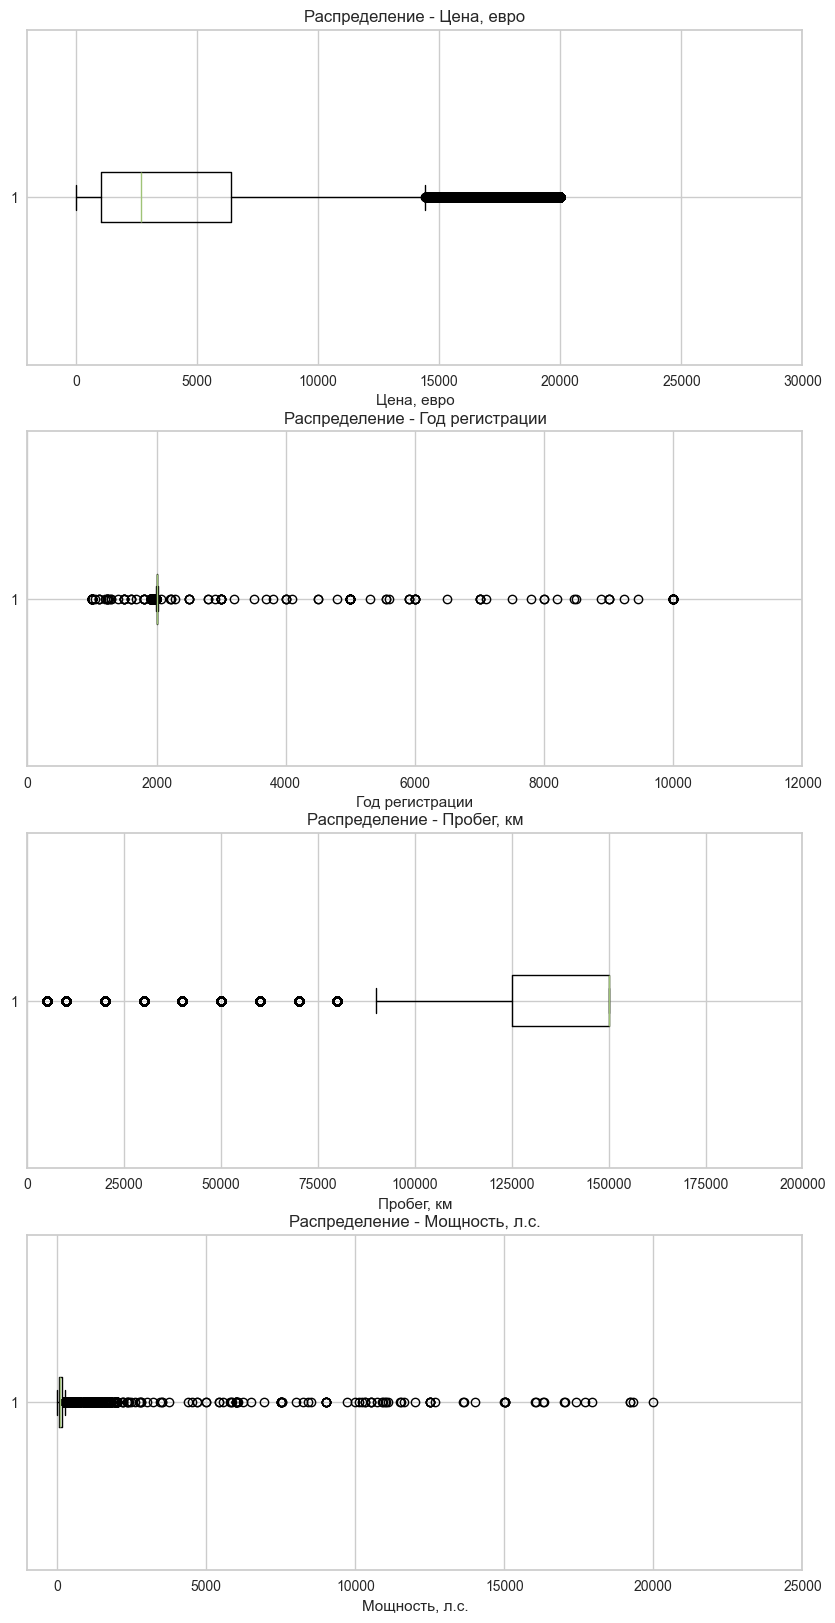

In [108]:
fig, axes = plt.subplots(nrows = 4, figsize = (10, 20))
left = [-2000, 0, 0, -1000]
right = [30000, 12000, 200000, 25000]
for i in range(len(num_col)):
    boxplot_build(df_autos, num_col[i], translate[i], 'Распределение - ' + translate[i], i, left[i], right[i])    

- Распределение пробега выглядит правдоподобно и значения на диаграмме соответствуют реальным
- Цена автомобилей также распределена приемлемо. Следует удалить только нулевые значения, которые не являются реальными и чтобы они не вводили модель МО в заблуждение
- В датасете присутствуют объявления, в которых мощность автомобилей чересчур велика. Это аномалии, и их следует удалить. Даже если это и реальная мощность из - за тюнинга автомобиля, то эти автомобили подпадают под класс особых авто и будут вносить помехи в обучении модели. Оставим автомобили с мощностью до 600 л.с.
- В году регистрации оставим значения с периода от 1950 до 2017 гг. Остальные удалим из датасета, так как это либо аномалии, либо выбросы в виде раритетных авто с правдоподобными годами выпуска, но которые опять же будут вводить в заблуждение модель
- Ещё по описанию на шаге 1 было указано, что последней датой и являющейся реальной к моменту выгрузки данных является 04.07.2016. Следовательно, объявления с автомобилями, регистрация которых 2017 года и позднее, не являются действительными. Удалим такие объявления

In [109]:
df_autos.sort_values(by = 'last_seen', ascending = False)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
327303,2016-03-24 18:55:33,600,sedan,1997,manual,75,golf,150000,3,petrol,volkswagen,no,2016-03-24,0,59872,2016-04-07 14:58:51
54852,2016-03-09 18:06:38,16900,small,2016,manual,90,clio,5000,2,gasoline,renault,no,2016-03-09,0,60326,2016-04-07 14:58:50
215705,2016-04-03 12:49:54,16700,coupe,2008,manual,170,a5,100000,9,petrol,audi,no,2016-04-03,0,72202,2016-04-07 14:58:50
4836,2016-03-21 15:58:17,6200,convertible,1997,auto,193,slk,150000,5,petrol,mercedes_benz,no,2016-03-21,0,65779,2016-04-07 14:58:50
325618,2016-03-19 23:41:33,5890,wagon,2008,manual,170,passat,150000,7,gasoline,volkswagen,no,2016-03-19,0,49219,2016-04-07 14:58:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169065,2016-03-05 14:06:47,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,2016-03-05,0,60489,2016-03-05 14:25:59
285695,2016-03-05 14:18:30,2850,sedan,1990,NaN,0,other,150000,2,petrol,mercedes_benz,no,2016-03-03,0,35781,2016-03-05 14:18:30
130462,2016-03-05 14:13:50,1200,wagon,2000,manual,115,passat,150000,5,other,volkswagen,no,2016-03-03,0,35606,2016-03-05 14:15:39
262341,2016-03-05 14:08:46,9000,sedan,2011,manual,109,c_reihe,90000,3,gasoline,volvo,no,2016-03-04,0,61348,2016-03-05 14:15:16


In [110]:
df_autos = df_autos[(df_autos['power'] < 600)]

In [111]:
df_autos = df_autos[(df_autos['power'] > 10)]

- Вероятно, что автомобили с нулевой мощностью - это автомобили не на ходу
- Либо же эти данные не указали сами владельцы, таким образом, их лучше удалить, чтобы не нарушать работу модели

In [112]:
df_autos = df_autos.loc[(df_autos['registration_year'] > 1950) &  (df_autos['registration_year'] < 2017)]

- Удалим автомобили стоимостью менее 50 евро

In [113]:
df_autos = df_autos[df_autos['price'] > 50]

- Возможно, что природа возникновения этих цен кроется в том, что с машиной какие - то проблемы в виде ареста или неоплаченных штрафов и т.п. и её реальной ценой является погашение задолженностей или кредита 

In [114]:
df_autos.describe()

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code,last_seen
count,295373,295373.000000,295373.000000,295373.000000,295373.000000,295373.000000,295373,295373.0,295373.000000,295373
mean,2016-03-21 13:10:03.458539008,4869.680482,2002.838404,120.675285,128323.441885,5.998317,2016-03-20 19:16:43.619152384,0.0,51242.773195,2016-03-30 05:17:52.701966592
min,2016-03-05 14:06:22,55.000000,1951.000000,11.000000,5000.000000,0.000000,2015-03-20 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:41:50,1350.000000,1999.000000,75.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30938.000000,2016-03-23 13:51:10
50%,2016-03-21 17:55:25,3200.000000,2003.000000,111.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,50259.000000,2016-04-04 03:16:05
75%,2016-03-29 14:49:27,6999.000000,2007.000000,150.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,72108.000000,2016-04-06 10:46:29
max,2016-04-07 14:36:58,20000.000000,2016.000000,585.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4611.219891,6.482883,53.739882,36695.417609,3.581507,NaN,0.0,25779.219352,NaN


In [115]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295373 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        295373 non-null  datetime64[ns]
 1   price               295373 non-null  int64         
 2   vehicle_type        295373 non-null  object        
 3   registration_year   295373 non-null  int64         
 4   gearbox             290086 non-null  object        
 5   power               295373 non-null  int64         
 6   model               295373 non-null  object        
 7   kilometer           295373 non-null  int64         
 8   registration_month  295373 non-null  int64         
 9   fuel_type           295373 non-null  object        
 10  brand               295373 non-null  object        
 11  repaired            295373 non-null  object        
 12  date_created        295373 non-null  datetime64[ns]
 13  number_of_pictures  295373 non-nul

In [116]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295373 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        295373 non-null  datetime64[ns]
 1   price               295373 non-null  int64         
 2   vehicle_type        295373 non-null  object        
 3   registration_year   295373 non-null  int64         
 4   gearbox             290086 non-null  object        
 5   power               295373 non-null  int64         
 6   model               295373 non-null  object        
 7   kilometer           295373 non-null  int64         
 8   registration_month  295373 non-null  int64         
 9   fuel_type           295373 non-null  object        
 10  brand               295373 non-null  object        
 11  repaired            295373 non-null  object        
 12  date_created        295373 non-null  datetime64[ns]
 13  number_of_pictures  295373 non-nul

- Необходимые исправления данных были проведены. Было удалено около 60 тыс. строк, т.е. чуть более 16 % от общего числа данных
- Мощность автомобиля по нижней границе не скорректирована, т.е. присутствуют значения мощности равные и находящиеся в пределах 0 л.с. При поиске этих значений было обнаружено 30 тыс. строк. Поэтому объявления с нулевыми значениями мощности были также удалены
- Проблему с мощностью можно было бы решить, заменив значения на мощности таких же моделей, если бы совпадал год, бренд и модель, а также присутствовал ещё один признак, а именно индекс модели, который и свидетельствует о мощности мотора. Но он отсутствует, поэтому оставим этот признак без изменений
- Визуализируем данные

## 2.5 Исследовательский анализ

In [117]:
cat_col = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
df_autos = df_autos[df_autos['brand'] != 'sonstige_autos']

In [118]:
df_autos_group = df_autos.pivot_table(index = 'brand', values = 'model', aggfunc = 'count')
df_autos_group.sort_values(by ='model', ascending = False).head(6)

,model
brand,
volkswagen,63905
opel,32379
bmw,32155
mercedes_benz,27279
audi,25562
ford,20638


In [119]:
brands_top_6 = df_autos_group.sort_values(by ='model', ascending = False).head(6).index.tolist()
print(brands_top_6)

['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi', 'ford']


In [120]:
df_autos_group.sort_values(by ='model', ascending = False).tail(6)

,model
brand,
jaguar,433
daewoo,408
lancia,379
rover,362
trabant,290
lada,157


- Удалим 'sonstige_autos', т.к. в них отсутствуют модели

In [121]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293691 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        293691 non-null  datetime64[ns]
 1   price               293691 non-null  int64         
 2   vehicle_type        293691 non-null  object        
 3   registration_year   293691 non-null  int64         
 4   gearbox             288462 non-null  object        
 5   power               293691 non-null  int64         
 6   model               293691 non-null  object        
 7   kilometer           293691 non-null  int64         
 8   registration_month  293691 non-null  int64         
 9   fuel_type           293691 non-null  object        
 10  brand               293691 non-null  object        
 11  repaired            293691 non-null  object        
 12  date_created        293691 non-null  datetime64[ns]
 13  number_of_pictures  293691 non-nul

In [122]:
brands_antitop_6 = df_autos_group.sort_values(by ='model', ascending = False).tail(6).index.tolist()
print(brands_antitop_6)

['jaguar', 'daewoo', 'lancia', 'rover', 'trabant', 'lada']


In [123]:
(df_autos.pivot_table(index = 'model', values = 'postal_code', aggfunc = 'count')
                         .sort_values(ascending = False, by = 'postal_code')
                         .tail(10))

,postal_code
model,
q3,13
amarok,12
gl,12
elefantino,7
samara,5
serie_2,5
i3,5
kalina,5
serie_3,3


In [124]:
list_to_delete = (df_autos.pivot_table(index = 'model', values = 'postal_code', aggfunc = 'count')
                         .sort_values(ascending = False, by = 'postal_code')
                         .tail(7).index.tolist()
                 )

In [125]:
print(list_to_delete)

['elefantino', 'samara', 'serie_2', 'i3', 'kalina', 'serie_3', 'range_rover_evoque']


In [126]:
df_autos = df_autos.loc[~(df_autos['model'].isin(list_to_delete))]

- Далее можно будет сформировать круговые диаграммы по моделям топ - 6 брендов по количеству автомобилей на рынке продаж и 6 брендов, автомобилей которых меньше всего представлено на рынке

- Построим круговые диаграммы для категориальных признаков

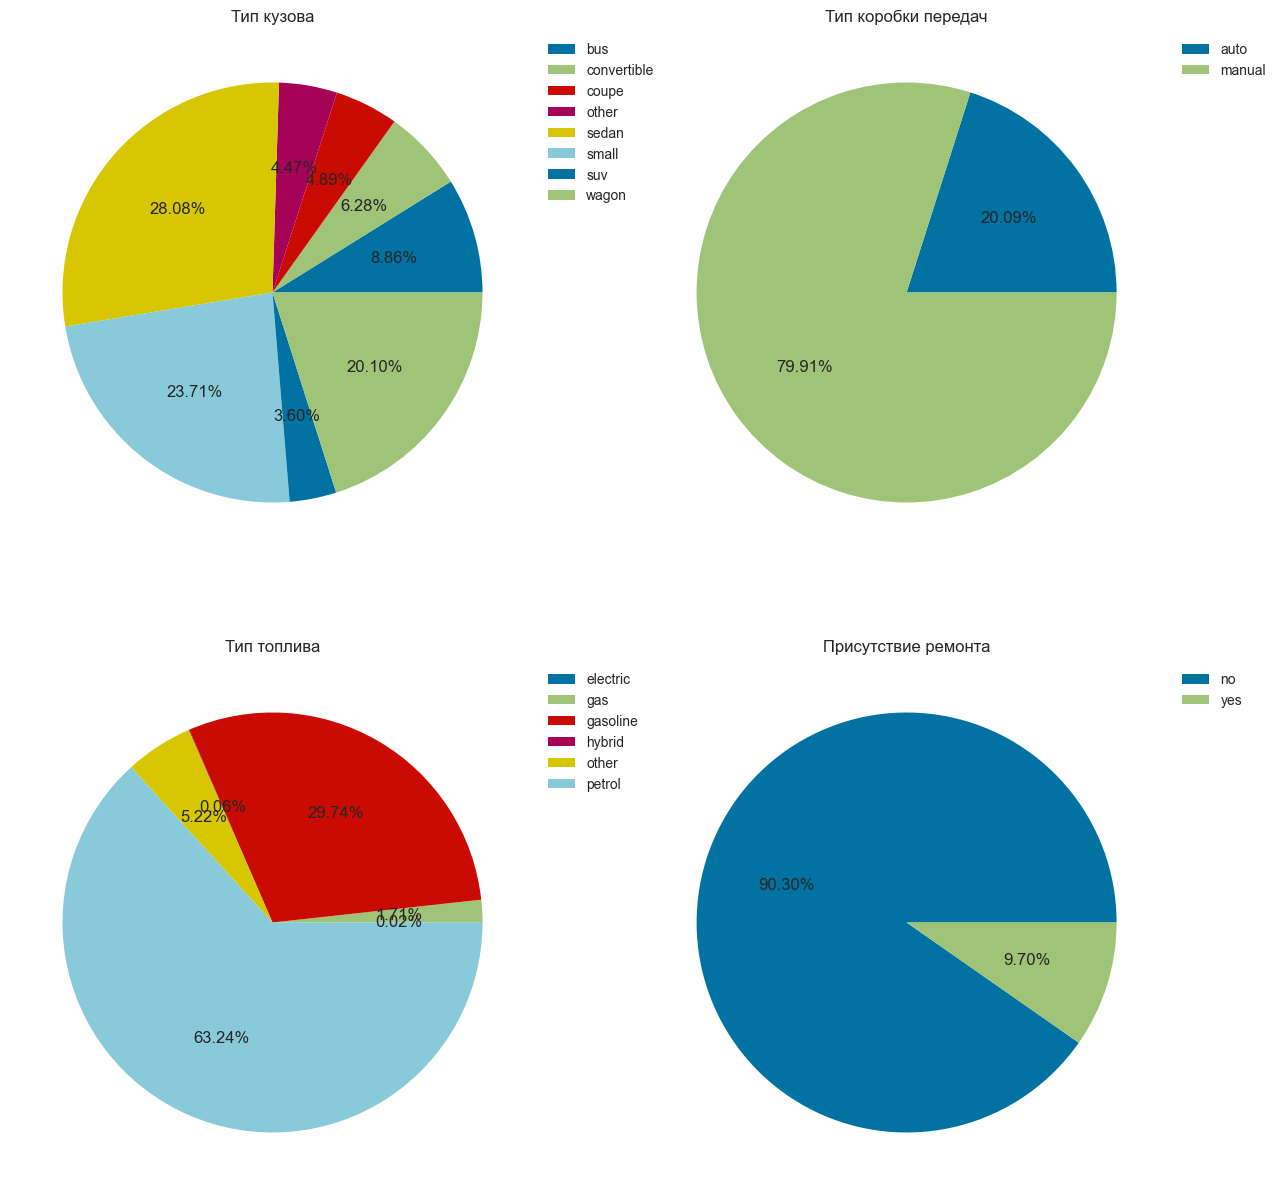

In [127]:
#def pie_build(df, column, support_column, title, i, j)
names = ['Тип кузова', 'Тип коробки передач', 'Тип топлива', 'Присутствие ремонта']
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
counter = 0
for i in range(2):
    for j in range(2):
        pie_build(df_autos, cat_col[counter], 'postal_code', names[counter], i, j)
        counter += 1

- Построим круговые диаграммы для вышеуказанных брендов  

- Топ 6 брендов по продажам

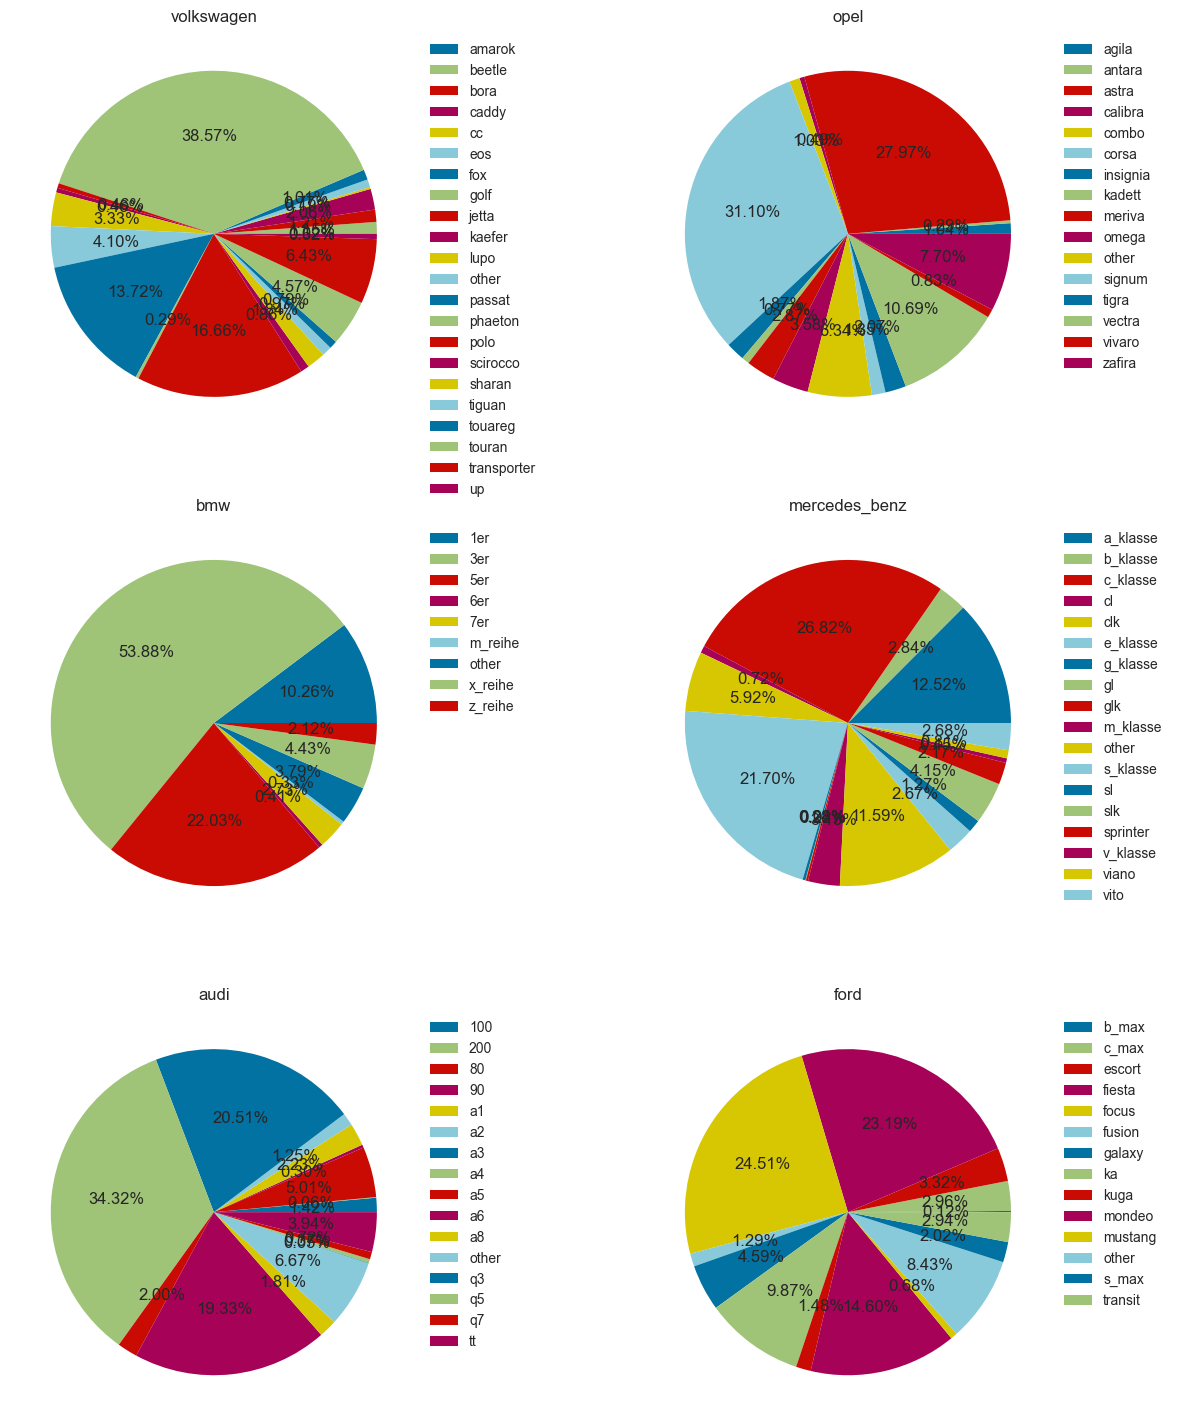

In [128]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 18))
counter = 0
for i in range(3):
    for j in range(2):
        pie_build(df_autos.loc[df_autos['brand'] == brands_top_6[counter]], 'model', 'postal_code', brands_top_6[counter], i, j)
        counter += 1

- Антитоп 6 брендов по продажам

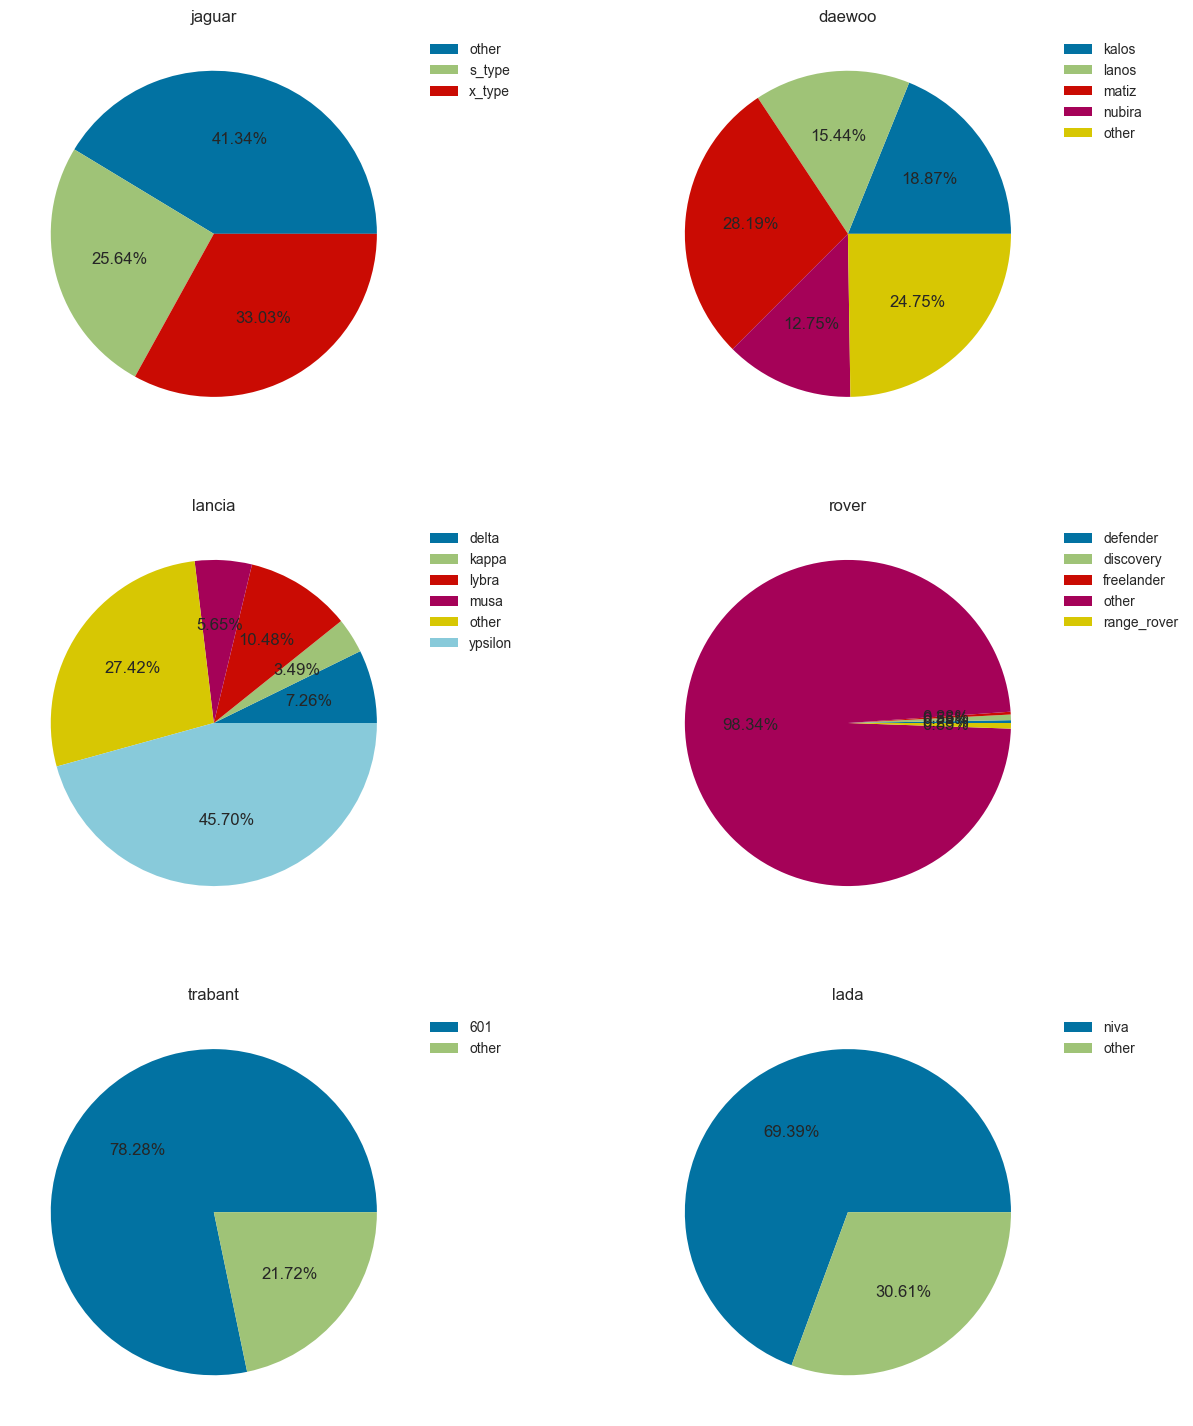

In [129]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 18))
counter = 0
for i in range(3):
    for j in range(2):
        pie_build(df_autos.loc[df_autos['brand'] == brands_antitop_6[counter]], 'model', 'postal_code', brands_antitop_6[counter], i, j)
        counter += 1

- Визуализируем количественные признаки

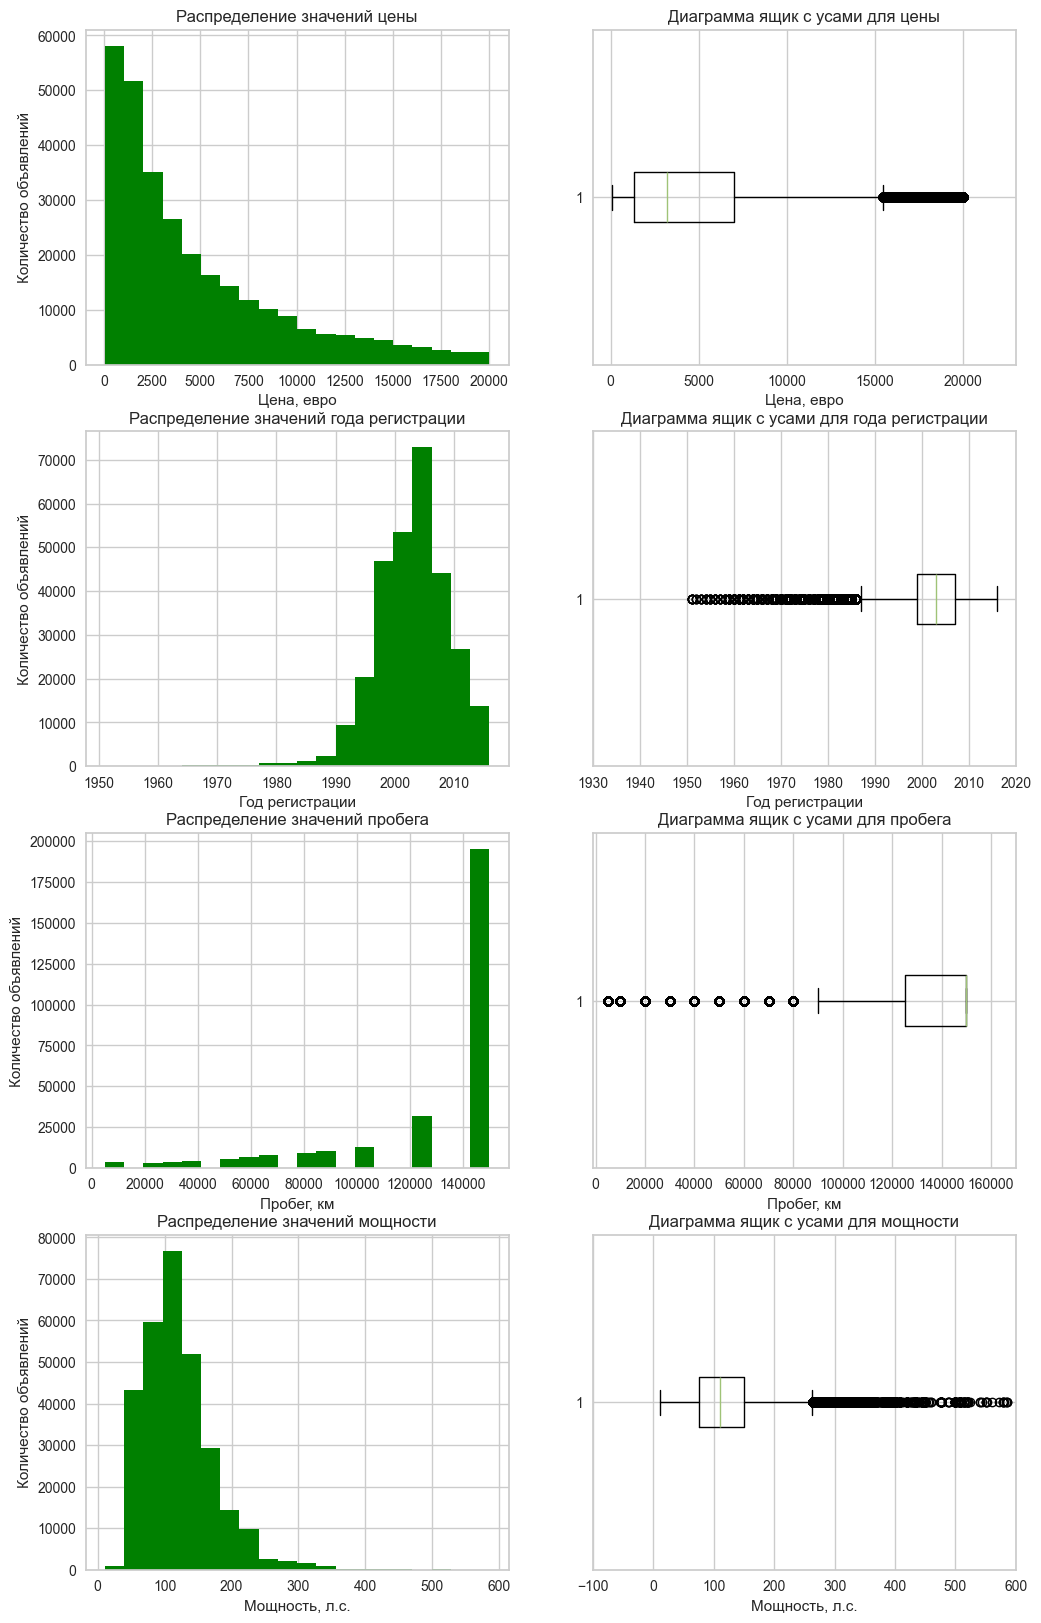

In [130]:
param_quant_of_bins = [20, 20, 20, 20]
param_lim_left = [-1000, 1930, -1000, -100]
param_lim_right = [23000, 2020, 170000, 600]
names = ['цены', 'года регистрации', 'пробега', 'мощности']
x_label_names = ['Цена, евро', 'Год регистрации', 'Пробег, км', 'Мощность, л.с.']
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 20))
for i in range(4):
    hist_build(df_autos,
               num_col[i],
               'green',
                x_label_names[i],
               'Количество объявлений',
               'Распределение значений ' + names[i],
               i,
               0,
               param_quant_of_bins[i],
               True
              )
    
    boxplot_build_2_dim(df_autos,
                  num_col[i],
                  x_label_names[i],
                  'Диаграмма ящик с усами для ' + names[i],
                  i,
                  1,
                  param_lim_left[i],
                  param_lim_right[i]       
                 )

In [131]:
(df_autos.pivot_table(index = 'model', values = 'postal_code', aggfunc = 'count')
                         .sort_values(ascending = False, by = 'postal_code')
                         .tail(10))

,postal_code
model,
b_max,25
9000,23
musa,21
charade,20
materia,17
200,16
kappa,13
q3,13
gl,12


Выводы по количественным признакам:
- На гистограмме цены видно, что с увеличением стоимости автомобилей снижается их количество, что является корректным
- Преимущественное количество объявлений приходится на года регистрации с 1990 по 2016
- На вторичном рынке также представлены в основном автомобили с пробегом 150 тыс. км. Вероятно, что для этого значения подразумеваются автомобили с пробегом и более 150 тыс. км
- Мощность автомобилей из объявлений в основном приходится на интервал до 230 л.с. 

Выводы по категориальным признакам:
- По круговым диаграммам видно, что в таких признаках как `тип кузова`, `тип топлива`, `присутствие ремонта`, `тип коробки передач` есть неравномерное распределение между количеством записей в датасете для значений, которые принимают признаки. Поэтому при обучении, вероятно, нужно будет применить стратификацию
- Также для дополнительных сведений было выведено топ - 6 и антитоп - 6 брендов по количеству представленных автомобилей на рынке
- Специфичнее всего представлены автомобили марки `range_rover`, т.к. 97% из всего числа моделей представляют `other`. Т.е. реальные модели на рынке представлены только 2 - 3 экземплярами, что будет теряться на фоне других моделей, которые представлены сотнями и тысячами экземпляров.

## 2.6 Корреляционный анализ

- Построим матрицу корреляции, а также подумаем, какие из признаков целесообразно убрать ввиду отсутствия полезной информации касаемо прогнозирования цены

In [132]:
interval_cols = ['price',
                 'registration_year',
                 'kilometer',
                 'power',
                 'month',
                 'postal_code'
                ]

In [133]:
df_autos_clean = df_autos.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures'], axis = 1)

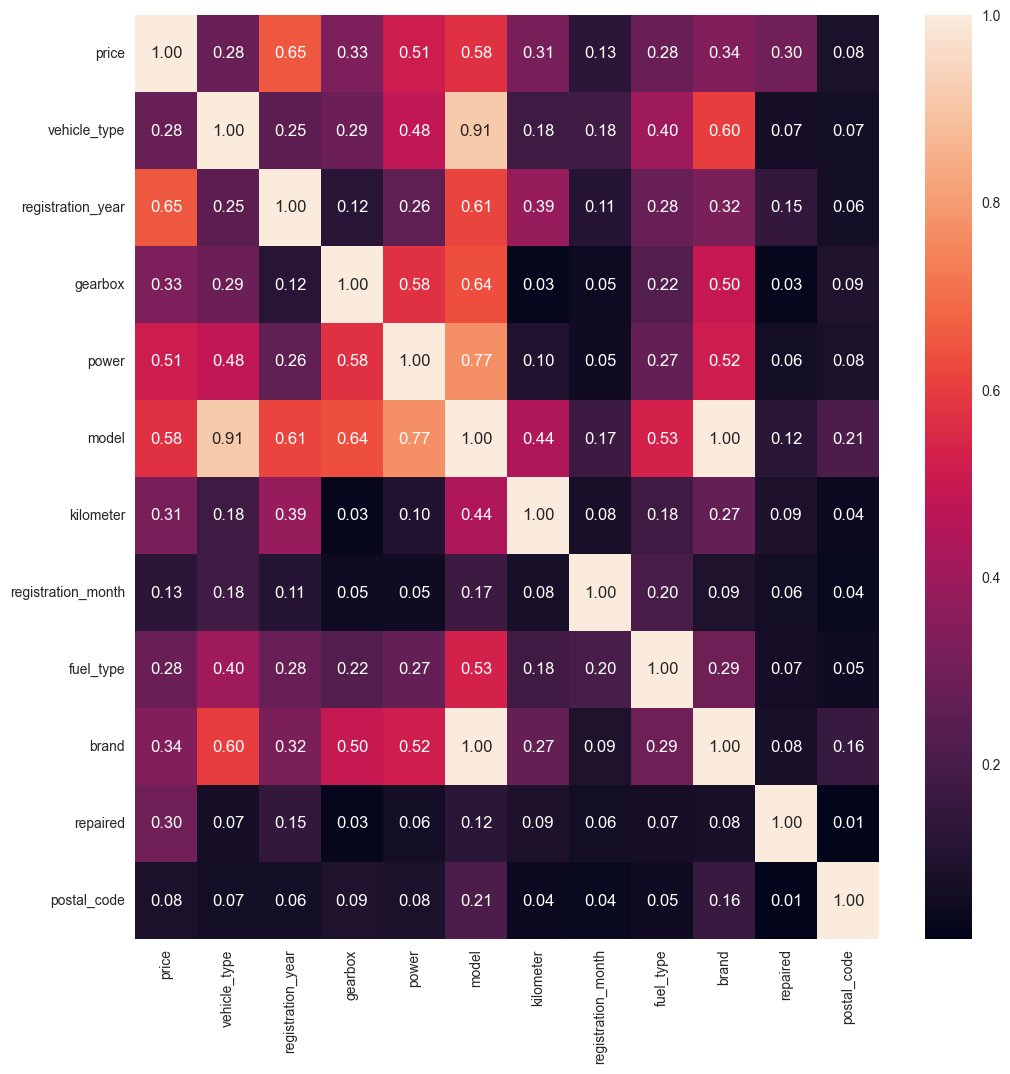

In [134]:
matrix_corr = phik_matrix(df_autos_clean, interval_cols = interval_cols);
fig, ax = plt.subplots(figsize = (12, 12));
sns.heatmap(matrix_corr, annot = True, fmt='.2f');

In [135]:
df_learn = df_autos_clean.drop(['postal_code', 'vehicle_type', 'brand'], axis = 1)

- Ключевыми признаками, обладающими высокой корреляцией с целевым признаком `price`, являются `registration_year`, `model`, `power`. Их коэффициенты корреляции составляют 0.64, 0.58, 0.51 соответственно, что является средним уровнем корреляции
- Признаки `gearbox`, `fuel_type`, `repaired` обладают слабой корреляцией с целевым признаком, коэффициент корреляции около 0.3
- У признаков `model` и `vehicle_type`, а также `model` и `brand` наблюдается сильная корреляция между собой, а именно коэффициенты корреляции 0.91 и 1, что свидетельствует о мультиколлинеарности. Поэтому при обучении воспользуемся признаком `model`, а остальные два не будем применять при обучении, чтобы не нарушать работу модели МО
- Следует убрать из датасета признаки, связанные с датой - `date_crawled`, `date_created`, `last_seen`, т.к. они не являются характеристиками автомобиля и отражают активность сайта и актуальность объявлений, нежели, действительно, оказывают влияние на стоимость автомобиля
- Также никакой важности для поставленной задачи не несут признаки `number_of_pictures` и `postal_code`. Первый признак отражает подробность объявления, а второй является уникальным номером каждого пользователя как идентификатор, который никак не влияет на цену, о чём и свидетельствует почти нулевая корреляции с целевым признаком
- Таким образом, для обучения модели используем следующие признаки:
    + Количественные: `registration_year`, `power`, `kilometer`
    + Категориальные: `gearbox`, `fuel_type`, `repaired`, `model`

# Шаг 3. Подготовка выборок для обучения моделей

- Для деления датасета на выборки и обучения моделей воспользуемся пайплайном, чтобы процесс подбора модели был автоматизированным

In [136]:
RANDOM_STATE = 777
TEST_SIZE = 0.2

In [137]:
# Объявим категеориальные и количественные признаки
target_columns = [
               'fuel_type',
               'repaired',
               'model',
               'gearbox'
                 ]

#bin_columns = [
#               'gearbox'
#              ]

num_columns = [
               'registration_year',
               'power',
               'kilometer'
              ]

In [138]:
# Разделение датасета
X = df_learn.drop(['price'], axis = 1)
y = df_learn['price']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [140]:
# SimpleImputer + OHE
target_pipe = Pipeline(
    [
        (
            'simpleImputer',
             SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'target',
             TargetEncoder()
        )
    ]
)

In [142]:
# Пайплайн для кодирования и масштабирования данных
data_preprocessor = ColumnTransformer(
    [
        ('target', target_pipe, target_columns),
#        ('bin', bin_pipe, bin_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder = 'passthrough'
)

- Так как предсказываемый признак `price` количественный, воспользуемся регрессионными моделями, а именно:
    + Линейная регрессия LinearRegression
    + Дерево решений DecisionTreeRegressor
    + Модель градиентного бустинга LGBMRegressor(необходимо использовать по условию проекта)

In [143]:
# Словарь для RandomizedSearchCV
param_distributions = [
            {
                # Описание DecisionTreeRegressor
                'models' : [DecisionTreeRegressor()],
                'models__max_depth' : range(40, 50),
                'models__min_samples_split' : range(10, 13),
                'preprocessor__num' : [StandardScaler()]
            },
#            {
                # Описание LinearRegression
#                'models' : [LinearRegression()],
#                'preprocessor__num' : [StandardScaler()]
#            },
            {
                # Описание LGBMRegressor
                'models' : [LGBMRegressor()],
                'models__num_leaves' : range(20, 25),
                'models__max_depth' : range(40, 50),
                'preprocessor__num' : [StandardScaler()]
            }
]

In [144]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor()) 
])

- Деление данных на выборки произведено, пайплайн сформирован

# Шаг 4. Обучение разных моделей

- Обучим модели при помощи инструмента автоматизированного поиска RandomizedSearchCV
- В качестве метрики используем RMSE(по условию задания проекта)
- Выведем время обучения моделей, т.к. это тоже является обязательной составляющей проекта

In [145]:
%%time
randomized_search = RandomizedSearchCV(
                        pipe_final,
                        param_distributions = param_distributions,
                        cv = 4,
                        scoring = 'neg_root_mean_squared_error',
                        random_state = RANDOM_STATE
                        #n_jobs = -1
                    )
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 176195, number of used features: 8
[LightGBM] [Info] Start training from score 4853.627265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 176195, number of used features: 8
[LightGBM] [Info] Start training from score 4841.140946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

In [146]:
print('Метрика лучшей модели на тренировочной выборке:', round((randomized_search.best_score_), 3))
cv_parametres = ['mean_fit_time',
                 'mean_score_time',
                 'mean_test_score',
                 'param_preprocessor__num',
                 'param_models__min_samples_split',
                 'param_models__num_leaves',
                 'param_models__max_depth',
                 'param_models'
                ]
for i in range(len(cv_parametres)):
    print(cv_parametres[i], ':', randomized_search.cv_results_.get(cv_parametres[i]))

Метрика лучшей модели на тренировочной выборке: -1755.59
mean_fit_time : [1.07013094 1.0161714  1.13229823 1.02238721 1.12467247 1.04417342
 1.1118139  1.13093549 1.04245692 0.98199785]
mean_score_time : [0.16434735 0.15506011 0.07506692 0.15358949 0.06978798 0.1471318
 0.07051736 0.07372773 0.15141714 0.142546  ]
mean_test_score : [-1759.89644104 -1759.89644104 -1887.67403285 -1755.58977239
 -1899.98855338 -1759.89644104 -1899.26739727 -1900.36365068
 -1765.30444346 -1759.89644104]
param_preprocessor__num : [StandardScaler() StandardScaler() StandardScaler() StandardScaler()
 StandardScaler() StandardScaler() StandardScaler() StandardScaler()
 StandardScaler() StandardScaler()]
param_models__min_samples_split : [-- -- 12 -- 11 -- 11 11 -- --]
param_models__num_leaves : [23 23 -- 24 -- 23 -- -- 22 23]
param_models__max_depth : [45 46 43 42 47 42 48 46 45 47]
param_models : [LGBMRegressor() LGBMRegressor() DecisionTreeRegressor() LGBMRegressor()
 DecisionTreeRegressor() LGBMRegressor() 

- Результаты работы моделей, а также их гиперпараметры и сам виж моделей выводится по окончании обучения
- Среди 10 моделей, выбранных случайным образом, лучшей оказалась модель, которая располагается 4 - ой по счёту
- Видно, что данная модель лидирует по среднему времени обучения, оно составляет 989 ms, в то время как остальным на это требуется более 1000 ms
- Среднее значение метрики RMSE также является самым лучшим среди остальных моделей и составляет 1755.59
- Наилучшее время предсказания характерно для модели, находящейся 10 -ой по счёту, а модель, которая оказалась лучше по предыдущим показателям, ближе к концу по этому параметру. Тем не менее, в совокупности всех трёх метрик 4 - ая модель показала лучший результат, поэтому использовать в бизнесе будем именно её
- Посмотрим на показатели 4 - ой модели на тестовой выборке
- На тренировочной выборке по модулю метрика RMSE меньше 2500, как и требуется по условию
- При каждом перезапуске проекта метрики по обучению меняются, поэтому выводы могут быть слегка искажены

In [147]:
%%time
y_pred = randomized_search.predict(X_test)
print('Значение метрики RMSE лучшей модели на тестовых данных:', round(root_mean_squared_error(y_test, y_pred), 3))
print('Время предсказания лучшей модели на тестовой выборке составляет:')

Значение метрики RMSE лучшей модели на тестовых данных: 1759.617
Время предсказания лучшей модели на тестовой выборке составляет:
CPU times: total: 641 ms
Wall time: 171 ms


In [148]:
print(f"Время обучения лучшей модели составляет {round(randomized_search.refit_time_, 2)} s")

Время обучения лучшей модели составляет 1.29 s


- Значение метрики попадает под условие задачи, т.е. меньше 2500 (составляет 1760)
- Время предсказания лучшей модели на тестовой выборке составило около 700 ms(cv_results показал 171 ms)
- Время обучения лучшей модели на тренировочных данных составило 1300 ms(cv_results показал 989 ms)
- Показатели по времени приемлемы и не заставляют долго ожидать результат
- Модель отработала стабильно, причём значения метрики RMSE на тестовой и тренировочной выборках отличаются незначительно
- Время подбора лучшей модели снизилось засчёт использования другого кодировщика `TargetEncoder`
- Проанализируем остатки предсказаний модели

# Шаг 5. Анализ работы моделей

- Построим гистограмму распределения остатков, а также диаграмму рассеяния и сделаем заключение о качестве работы модели

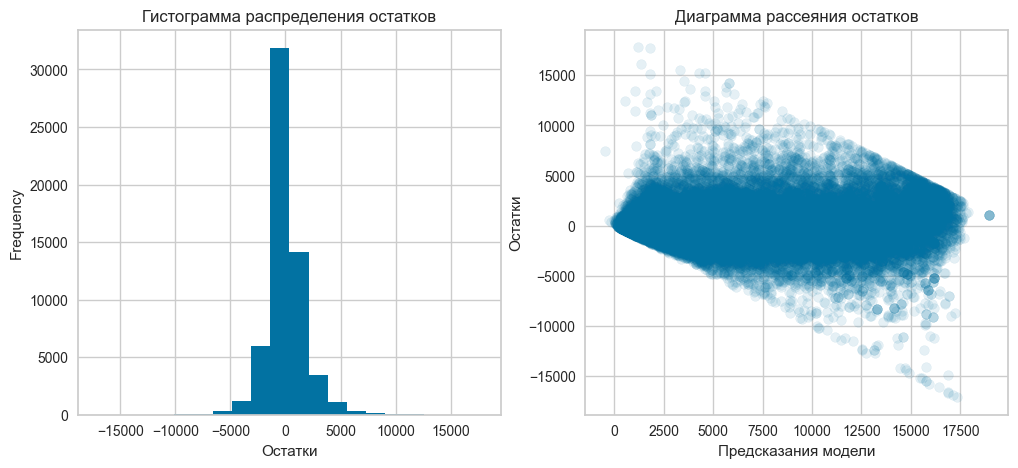

In [149]:
residuals = y_test - y_pred
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5));
axes[0].set_title('Гистограмма распределения остатков');
residuals.plot(kind = 'hist', bins = 20, ax = axes[0]);
axes[0].set_xlabel('Остатки');

axes[1].set_title('Диаграмма рассеяния остатков');
axes[1].scatter(x = y_pred, y = residuals, alpha = 0.1);
axes[1].set_xlabel('Предсказания модели');
axes[1].set_ylabel('Остатки');

In [150]:
r2 = r2_score(y_test, y_pred)
print(f"Коэффициент детерминации для модели равен {round(r2, 3)}")

Коэффициент детерминации для модели равен 0.854


- У гистограммы присутствует вид нормального распределения
- На диаграмме рассеяния остатков разброс специфический, но при этом большинство данных попадают в трубку от - 5000 до 5000, что соответствует некоторой однородности на всём интервале значений
- Значение коэффициента детерминации r2 стремится к 1(равно 0.854), что также является хорошим показателем
- Таким образом, лучшей моделью оказался LGBMRegressor c параметрами max_depth = 42, num_leaves = 24

# Шаг 6. Выбор лучшей модели и выводы о проделанной работе

## Выводы о лучшей модели

- Лучшей моделью оказался LGBMRegressor c параметрами max_depth = 42, num_leaves = 24
- Предсказания данной модели оказались качественными. Об этом свидетельствуют гистограмма и диаграмма рассеяния остатков. Безусловно, на диаграммах присутствуют значения, для которых характерна высокая ошибка предсказания, но, вероятно, это исключения из правил, которые представлены специфическими признаками
-  Дальнейшее увеличение подробности условий дерева для модели LGBMRegressor в виде корректировки параметров приведёт к переобучению и снижению показателей на тестовой выборке, что нежелательно
-  Метрика RMSE оказалась на тестовой выборке менее 2500, а именно 1760, что соответствует условию задания

## Выводы по критериям заказчика

- Модель работает качественно для объявлений, не обладающих специфическими свойствами. Для объявлений с ценой до 2500 евро ошибка в предсказаниях незначительна. Для объявлений с ценой более 2500 евро ошибка в основном не превышает 5000 евро
- Для лучшей модели время обучения составило около 1350 ms, а время предсказания в пределах 700 ms. Результат приемлемый с учётом масштаба датасета